In [1]:
import warnings
import matplotlib.animation as animation 
from IPython import display 

warnings.filterwarnings('ignore')

In [2]:
""" Smoke Plume
Hot smoke is emitted from a circular region at the bottom.
The simulation computes the resulting air flow in a closed box.
"""
#from phi.flow import *  # minimal dependencies
# from phi.torch.flow import *
# from phi.tf.flow import *
from phi.jax.flow import *

Res       = 200   # Resolution
Smoke_Pos = 50

Walls = Obstacle(union(
    [Box(x=(20, 60), y=(50, 51)), #bottom wall
    Box(x=(80, 100), y=(70, 71)), #top bar
    Box(x=(20, 21), y=(50, 65)),
    Box(x=(45, 46), y=(50, 65)),
    Box(x=(30, 31), y=(80, 100)),
    ]
))



velocity = StaggeredGrid(0, x=Res, y=Res, bounds=Box(x=100, y=100))  # or CenteredGrid(...)
smoke = CenteredGrid(0, ZERO_GRADIENT, x=2*Res, y=2*Res, bounds=Box(x=100, y=100))
inflow = 0.05 * resample(Sphere(x=Smoke_Pos, y=10, radius=5), to=smoke, soft=True)

pressure = None


@jit_compile  # Only for PyTorch, TensorFlow and Jax
def step(v, s, p, dt=1.):
    s = advect.mac_cormack(s, v, dt) + inflow
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, Walls, Solve('auto', 1e-4, 0, x0=p))
    return v, s, p

2023-10-19 15:26:18.456552: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Max


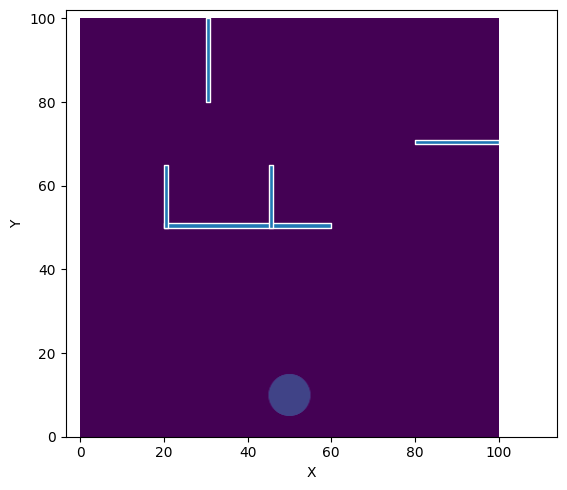

In [8]:
for _ in range(1):
    velocity, smoke, pressure = step(velocity, smoke, pressure)
    plot(vis.overlay(smoke,Walls.geometry), alpha=1, show_color_bar=False, animate='time')

In [4]:
trj = iterate(step, batch(time=100), velocity, smoke, pressure)

KeyboardInterrupt: 

In [6]:
plot(vis.overlay(trj[1],Walls.geometry), alpha=1, show_color_bar=False, animate='time')

NameError: name 'trj' is not defined

In [57]:
trj[1].uniform_values().numpy('time,x,y,vector').shape

(101, 400, 400, 1)

In [68]:
trj[0].uniform_values().numpy('time,x,y,vector').shape

(101, 201, 201, 2)

In [74]:
import h5py

hf = h5py.File("Smoke-Flow-Data.h5", "w")
g1 = hf.create_group('experiment-1')

In [75]:
g1.create_dataset('velocity', data=trj[0].uniform_values().numpy('time,x,y,vector'))

<HDF5 dataset "velocity": shape (101, 201, 201, 2), type "<f4">

In [76]:
g1.create_dataset('density', data=trj[1].uniform_values().numpy('time,x,y,vector'))

<HDF5 dataset "density": shape (101, 400, 400, 1), type "<f4">

In [83]:
g1.attrs['Smoke_Pos'] = Smoke_Pos

In [85]:
hf.close()